In [ ]:

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
import matplotlib.pyplot as plt
import sys
import os
import access_era_5 as access_era_5
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
sys.path.append(os.path.abspath(".."))

import utils.lstm as lstm
from utils.logger import Logger
logger = Logger.configurar_logger(nome_arquivo="biLstmEra5.log", nome_classe="BiLstm Era5")
logger.info("Iniciando script de previsão com BiLSTM ERA 5(TensorFlow/Keras).")

2025-09-29 19:18:25.440850: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


/home/pbose/tcc/pesquisa/era5/access_era_5.py:9: UserWarning: The specified chunks separate the stored chunks along dimension "valid_time" starting at index 100. This could degrade performance. Instead, consider rechunking after loading.
  ds = xr.open_dataset(caminho_completo, chunks={"valid_time": 100})


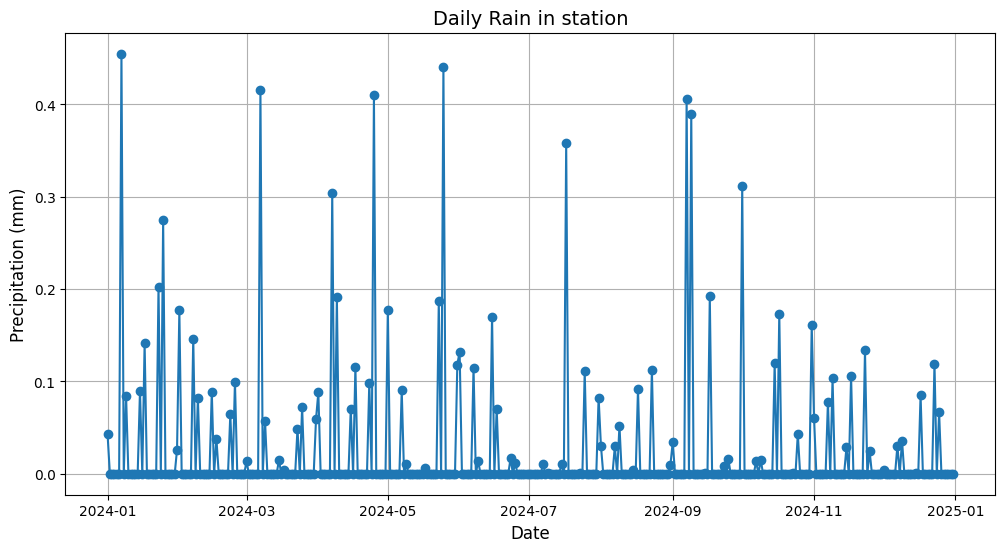

In [ ]:
timeseries = access_era_5.recuperar_dados_era_5()
logger.info(f"Dados carregados com sucesso. Total de {len(timeseries)} registros.")
dias = timeseries['valid_time']

total_chuva = timeseries['tp']
dias = pd.to_datetime(dias)

# Faz o plot
plt.figure(figsize=(12,6))
plt.plot(dias, total_chuva, marker="o", linestyle="-")

plt.title("Daily Rain in station", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Precipitation (mm)", fontsize=12)
plt.grid(True)
plt.show()


In [ ]:
lookback = 30
logger.info(f"Preparando sequências com lookback de {lookback} dias.")
X, y = lstm.create_sequences_pytorch(total_chuva, lookback=lookback)
train_size = int(len(timeseries) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


dates_aligned = dias[lookback:]
train_date, test_date = dates_aligned[:train_size] , dates_aligned[train_size:]
logger.info(f"Sequências criadas. Treino: {len(X_train)} amostras, Teste: {len(X_test)} amostras.")

torch.Size([256, 30, 1]) torch.Size([256, 1])
torch.Size([80, 30, 1]) torch.Size([80, 1])


In [ ]:
epochs = 20
# Building the model
model = Sequential()
model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=(lookback, 1)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.2))
model.add(Dense(1))  

logger.info(f"Iniciando treinamento por {epochs} épocas.")

model.compile(optimizer="adam", loss="mse")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=epochs,
    batch_size=32
)
logger.info("Treinamento concluído.")

# --- Previsão ---
logger.info("Realizando previsões no conjunto de teste.")
pred = model.predict(X_test)
#pred_rescaled = scaler.inverse_transform(pred)
#real_rescaled = scaler.inverse_transform(y_test)
rmse = np.sqrt(mean_squared_error(y_test, pred))
mse = mean_squared_error(y_test, pred)
mae = mean_absolute_error(y_test, pred)
logger.info(f"Avaliação do Modelo - RMSE: {rmse:.4f}, MSE: {mse:.4f}, MAE: {mae:.4f}")

Epoch 1/20


/home/pbose/tcc/pesquisa/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 0.0058 - val_loss: 0.0016
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0057 - val_loss: 0.0020
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0056 - val_loss: 0.0016
Epoch 4/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0058 - val_loss: 0.0018
Epoch 5/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0056 - val_loss: 0.0016
Epoch 6/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0056 - val_loss: 0.0017
Epoch 7/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0056 - val_loss: 0.0017
Epoch 8/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0057 - val_loss: 0.0016
Epoch 9/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0058 - val_loss: 0.0017
Epoch 10/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0056 - val_loss: 0.0015
Epoch 11/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0056 - val_loss: 0.0018
Epoch 12/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0055 - val_loss: 0.0015
Epoch 13/20


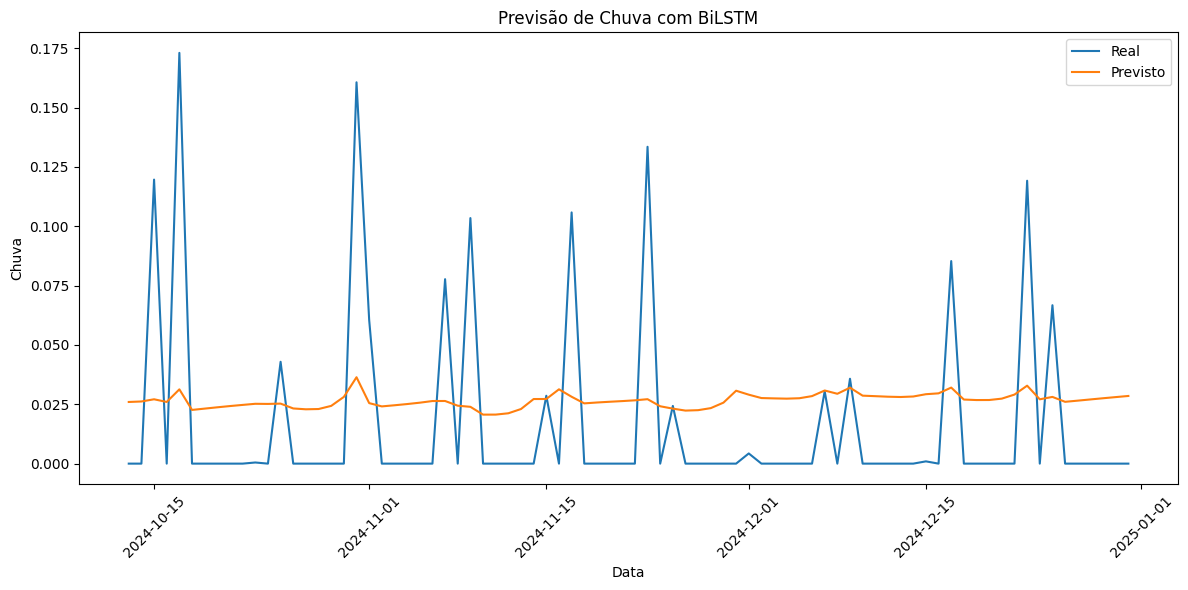

In [ ]:
logger.info("Gerando gráfico de previsão final.")
plt.figure(figsize=(12,6))
plt.plot(test_date, y_test, label="Real")
plt.plot(test_date, pred, label="Previsto")
plt.legend()
plt.title("Previsão de Chuva com BiLSTM")
plt.xlabel("Data")
plt.ylabel("Chuva")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
logger.info("Script BiLSTM ERA 5(TensorFlow/Keras) finalizado.")